### Import of libraries and data

In [1]:
# !pip install mlxtend

In [2]:
# !pip uninstall scikit-learn

In [3]:
# !pip install scikit-learn==1.2.2

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from scipy import stats as st

import sklearn
from sklearn.preprocessing import normalize
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.utils import resample
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import roc_auc_score, recall_score, f1_score, accuracy_score

from sklearn.feature_selection import SequentialFeatureSelector
# from mlxtend.feature_selection import SequentialFeatureSelector

import warnings
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_excel(r'C:\Users\aksen\coursework\data.xlsx') # file with the main dataset
names = pd.read_excel(r'C:\Users\aksen\coursework\Names(2).xlsx') # file with feature names

In [14]:
df.head()

,licdate,regn,date,rang,default,h1,h101,h12,h2,h3,...,exp_nsc2,fch_nsc2,mds_nsc2,nra_nsc2,rus_nsc2,snp_nsc2,date3,default2,ent_name2,defaultfull
0,240360,2,40360,0.564626,0,0.0,0.60,0.0,47.970001,75.019997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0
1,240452,2,40452,0.201908,0,0.0,0.03,0.0,29.790001,63.020000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0
2,240544,2,40544,0.705000,0,0.0,0.10,0.0,73.769997,70.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0
3,240634,2,40634,0.931361,0,0.0,0.08,0.0,24.459999,62.980000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0
4,240725,2,40725,0.417946,0,0.0,0.02,0.0,36.720001,67.519997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,.,0


In [15]:
ones = (df["defaultfull"].sum()/df.shape[0]) * 100
zeros = 100 - ones

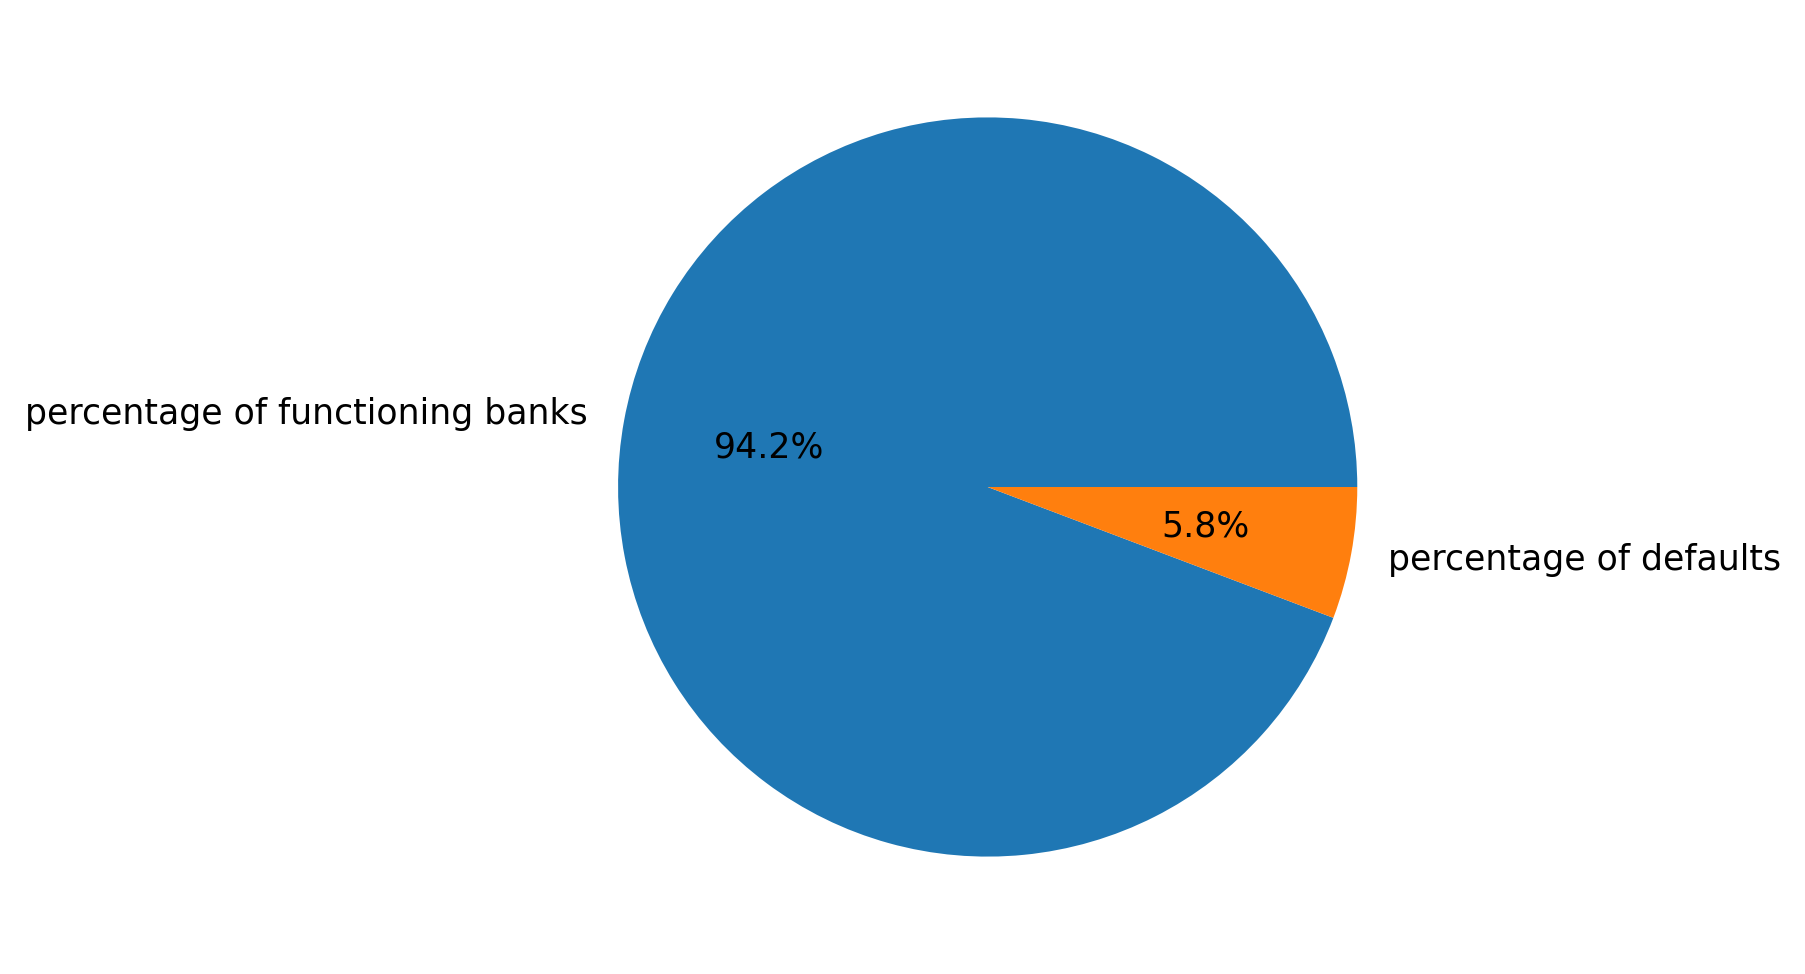

In [16]:
fig, ax = plt.subplots(dpi=250)
plt.pie([zeros, ones], labels=['percentage of functioning banks', 'percentage of defaults'], autopct='%1.1f%%');

### Creating additional explanatory variables

Описание полей: 

'licdate' - дата + номер лицензии


'regn', 'regn2' - номер лицензии банка


'date', 'date3' - временные пометки


'rang'


'default', 'default2', 'default3', 'defaultfull' - логические переменные для указания дефолта 


'h1', 'h101', 'h12', 'h2', 'h3', 'h4', 'h7', 'h91' - нормативы центрального банка (91, 101 - 9.1, 10.1)


'aa' - Акционерный капитал (актив)


'ap' - Акционерный капитал (пассив)


'bl'


'ca' - Счета собственного капитала (актив)


'cp' - Счета собственного капитала (пассив)


'ma' - Основные средства


'mp' - Амортизация


'op' - Прочие пассивы


'or' - Обязательные резервы


'r' - Резервы на возможные потери


's' - Купленные ценные бумаги (актив)


'v' - Драгоценные металлы 


'w' - Наличность


'z' - Выпущенные ценные бумаги (пассив)


'da' - Депозиты коммерческих организаций


'db' - Депозиты банков (МБК)


'dc' - Депозиты ЦБ


'df' - Депозиты иностранных организаций


'dg' - Депозиты государственных органов


'dh' - Депозиты домашних хозяйств


'dn' - Депозиты НКО


'di' - Депозиты финансовых организаций


'n' - 


'k' - 


'la' - Кредиты коммерческим организациям




'lb' - Кредиты банкам (МБК)


'lc' - Кредиты ЦБ


'lf' - Кредиты иностранным организациям


'lg' - Кредиты государственным органам


'lh' - Кредиты домашним хозяйствам


'li' - Кредиты финансовым организациям


'ln' - Кредиты НКО


'active' - активы


'size' - log(actives)


'nonf'


'durcha' - депозиты юр. лиц к чистым активам


'recha' - резервы к чистым активам


'orcha' - обязательные резервы к чистым активам


'var119'


'okpo'


'ogrn' - основной государственный регистрационный номер


!!! Депозиты к юр лицам = da + df, депозиты коммерческих и иностранных организаций


А.М. Карминский  НИУ ВШЭ, Москва 
А.В. Костров  НИУ ВШЭ, Москва 


##### Моделирование вероятности дефолта российских банков: расширенные возможности


++++++++++ Отношение собственных средств к чистым активам - sk_ca

- Отношение балансовой прибыли к чистым активам - bp_ca

++++++++++ Отношение ликвидных активов к чистым активам - la_ca 

++++++++++ Отношение объема негосударственных ценных бумаг к чистым активам ncb_ca s_active

- Отношение просроченной задолженности по ссудам к кредитам экономике pzs_ke

- Отношение оборотов по корреспондентским счетам к чистым активам oks_ca

++++++++++ Отношение ликвидных активов к обязательствам до востребования la_ov - h2

++++++++++ Логарифм чистых активов ln_ca / SIZE 

- Отношение операционных доходов банка к чистой прибыли odb_cp

- Отношение чистой прибыли к чистым активам cp_ca

+- Отношение ликвидных активов к долговым обязательствам государственным и органов местного самоуправления la_gdo

+- Отношение ликвидных активов к обязательствам на срок свыше одного года la_solong

++++++++++ Отношение долговых обязательств государственных и органов местного самоуправления к чистым активам gdo_ca

Отношение работающих активов к чистым активам ra_ca

- Отношение депозитов физических лиц до 30 дней к депозитам физических лиц vdfl30_dfl

- Отношение расходов на содержание аппарата к операционным расходам банка rsa_orb

++++++++++ Отношение резервов к чистым активам res_ca - recha 

##### Feature generation

In [17]:
# sk_ca

df['ca_active'] = df['ca'] / df['active']

df['ma_active'] = df['ma'] / df['active']

df['ca+cp_active'] = df['ca'] + df['ca']
df['ca+cp_active'] = df['ca+cp_active'] / df['active']

# la_ca

df['s+w+v_active'] = df['s'] + df['v'] + df['w']
df['s+w+v_active'] = df['s+w+v_active'] / df['active']

# ncb_ca

df['s_active'] = df['s'] / df['active']

# gdo_ca

df['gdo_ca'] = df['lg']/df['active']

# la_gdo

# df['la_gdo'] = df['s']/df['lg']

# la_solong

# solong = ['lb_long', 'lc_long', 'lf_long', 'lg_long', 'lh_long', 'li_long', 'ln_long']

# l_long = df['la_long']

# for el in solong:
#     l_long = l_long + df[el]

# df['la_solong'] = df['s']/l_long

##### Ratings normalization + ratings filtration 

In [18]:
ratings = []

for c in list(df.columns):
    if (c.find('consrank') != -1) or (c.find('nsc') != -1):
        ratings.append(c)
        regul = StandardScaler()
        regul.fit(np.array(df[df[c].notnull()][c]).reshape(-1, 1))
        
        df[c] = regul.transform(np.array(df[c].fillna(regul.mean_[0])).reshape(-1, 1)).reshape(df.shape[0])
        
print(ratings)

df_ratings = df[ratings]
df['have_rating'] = df_ratings.sum(axis=1)

df['have_rating'] = df['have_rating'].apply(lambda x: 1 if x > 0 else 0)

['consrank', 'akm_nsc', 'exp_nsc', 'fch_nsc', 'mds_nsc', 'nra_nsc', 'rus_nsc', 'snp_nsc', 'consrank2', 'akm_nsc2', 'exp_nsc2', 'fch_nsc2', 'mds_nsc2', 'nra_nsc2', 'rus_nsc2', 'snp_nsc2']


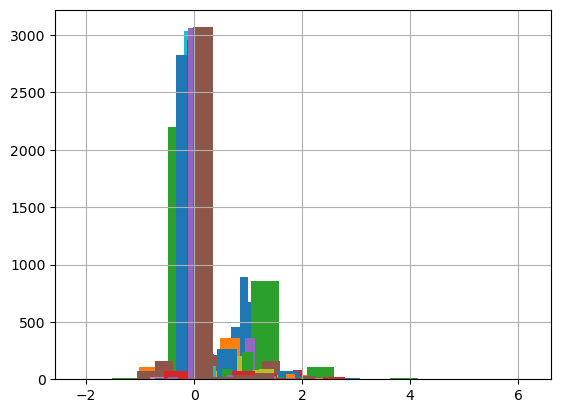

In [19]:
for i in ratings:
    df[df['have_rating'] != 0][i].hist(bins = 15)

We have ordinal variables - date
And nominal - regn, name

The following features do not contribute to the model performance as they copy other existing variables

In [20]:
df = df.drop(['regn2'], axis=1)
df = df.drop(['date3'], axis=1)
df = df.drop(['date_str'], axis=1)
df = df.drop(["ent_name", "ent_name2"], axis=1)

In [21]:
for col in ['nonf', 'var119']: 
    df[col] = df[col].fillna(df[col].mean())

##### Adding lags 

In [22]:
prepared = set()
filter_lag_1 = []

for el in list(df['regn']):
    
    if el in prepared:
        filter_lag_1.append(1)
        
    else:
        filter_lag_1.append(0)
        
    prepared.add(el)

filter_lag_2 = filter_lag_1.copy()

i = 0
while i < len(filter_lag_2):
    if filter_lag_2[i] == 0:
        filter_lag_2[i+1] = 0
        i += 2
    else:
        i += 1

In [23]:
df = df.sort_values(['regn', 'date'])

number_columns = df.select_dtypes(np.number).columns

exclude=set(['licdate', 'regn', 'date', 'default', 'default2', 'default3', 'defaultfull', 'date3', 'date_str', 'ent_id', 'ent_id2', 'rang', 'have_rating'])
exclude = exclude.union(ratings)

lags_columns = []

for col in number_columns:
    if col in exclude:
        continue
        
    else:
        df[f"{col}_lag_1"] = df[col].shift(1).fillna(0)
        df[f"{col}_lag_2"] = df[col].shift(2).fillna(0)
        
        df[f"{col}_lag_1"] = df[f"{col}_lag_1"] * filter_lag_1
        df[f"{col}_lag_2"] = df[f"{col}_lag_2"] * filter_lag_2
        
        lags_columns.append(f"{col}_lag_1")
        lags_columns.append(f"{col}_lag_2")

##### Distribution of defaults between two datasets

In [24]:
df_with_ratings = df[df['have_rating'] == 1]
df_no_ratings = df[df['have_rating'] == 0]

df_no_ratings = df_no_ratings.drop(ratings, axis=1)

In [26]:
df.shape

(17831, 309)

In [27]:
df_with_ratings.shape

(3186, 309)

In [28]:
df_no_ratings.shape

(14645, 293)

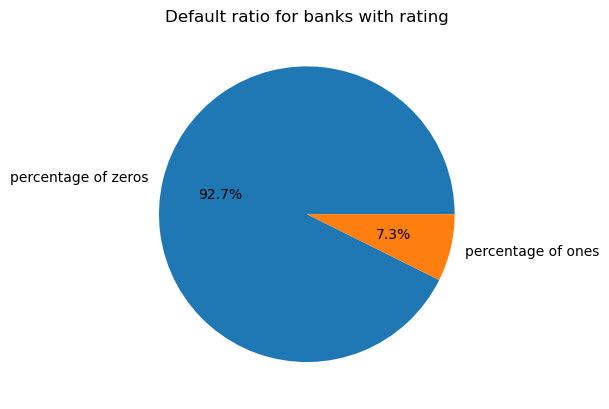

In [31]:
ones = (df_with_ratings["defaultfull"].sum()/df_with_ratings.shape[0]) * 100
zeros = 100 - ones

fig, ax = plt.subplots(dpi=100)
plt.pie([zeros, ones], labels=['percentage of zeros', 'percentage of ones'], autopct='%1.1f%%');
plt.title('Default ratio for banks with rating')
plt.show()

Text(0.5, 1.0, 'Default ratio for banks without rating')

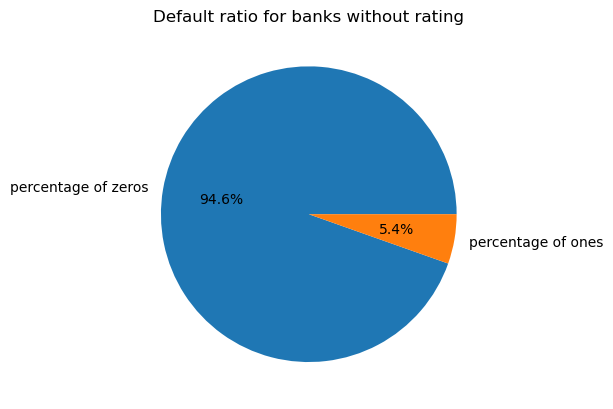

In [32]:
ones = (df_no_ratings["defaultfull"].sum()/df_no_ratings.shape[0]) * 100
zeros = 100 - ones

fig, ax = plt.subplots(dpi=100)
plt.pie([zeros, ones], labels=['percentage of zeros', 'percentage of ones'], autopct='%1.1f%%');
plt.title('Default ratio for banks without rating')

Normalization

In [20]:
"""
Hot fix for columns with nan
"""

cols_with_nan = df_with_ratings.isnull().describe().T
cols_with_nan = list(cols_with_nan[cols_with_nan['unique'] == 2].T.columns)

df_with_ratings = df_with_ratings.drop(cols_with_nan, axis=1)
df_no_ratings = df_no_ratings.drop(cols_with_nan, axis=1)

## Models

In [21]:
"""
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
"""

'\nLogisticRegression\nKNeighborsClassifier\nDecisionTreeClassifier\nRandomForestClassifier\nAdaBoostClassifier\n'

In [22]:
"""
Check for nan columns
"""

trash = df_with_ratings.isnull().describe().T
list(trash[trash['unique'] == 2].T.columns)

[]

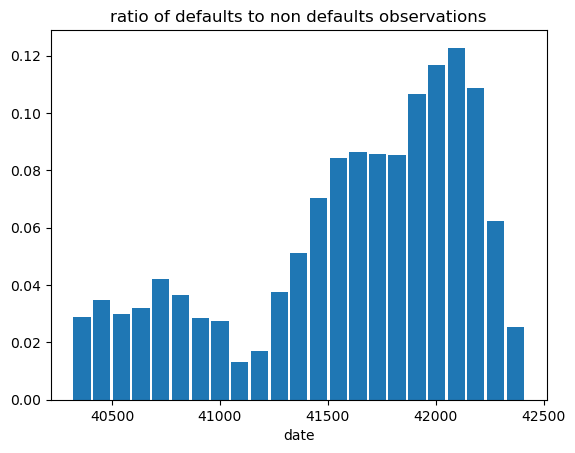

In [23]:
counts = []
lengths = []

for d in df['date'].unique():
    counts.append(df[df['date'] == d]['defaultfull'].sum())
    lengths.append(len(list(df[df['date'] == d]['defaultfull'])))
    
anal_time = pd.DataFrame()

anal_time['date'] = list(df['date'].unique())
anal_time['counts'] = counts
anal_time['lengths'] = lengths
anal_time['ratio'] = anal_time['counts']/anal_time['lengths']

plt.bar(x=list(df['date'].unique()), height=anal_time['ratio'], width=80)
plt.xlabel('date')
plt.title('ratio of defaults to non defaults observations');

In [24]:
def draw_confusion_matrix(pred, true_val):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for i in range(len(pred)):
        if pred[i] == true_val[i]:
            if pred[i] == 1:
                tp += 1
            else:
                tn += 1
        
        else:
            if pred[i] == 1:
                fn += 1
            else:
                fp += 1
    
#     tp = tp/len(pred)
#     tn = tn/len(pred)
#     fp = fp/len(pred)
#     fn = fn/len(pred)
    
    matrix_conf = pd.DataFrame([[tp, fp], [tn, fn]], columns=['p', 'n'], index=['true', 'false'])
    sns.heatmap(matrix_conf, annot=True)
    
# draw_confusion_matrix([1, 0, 0], [0, 1, 0])

In [25]:
def regularize(data):
    
    regul = StandardScaler()
    return pd.DataFrame(regul.fit_transform(data), columns=data.columns)
    

def test_model(data, model, name='no name', upsample=True, printing=True, n_splits=5):
    
    y_df_numbers = data['defaultfull']
    
#     y_df_numbers = data['default']
    x_df_numbers = data.drop(['default', 'defaultfull'], axis=1)

    train_test_split = StratifiedKFold(n_splits=n_splits)
    split = train_test_split.split(x_df_numbers, y_df_numbers)
    
    if printing:
        print(f'--- {name} ---')
        print('\t', 'recall, accuracy, roc_auc, f_1', sep='')
        print()

    mean_roc_auc = 0
    
    regul = StandardScaler()
    
    regul.fit(x_df_numbers)

    for i in range(n_splits):
        
        if printing:
            print(i + 1, end='\t')

        current_split = next(split)

        train_x, train_y = x_df_numbers.iloc[current_split[0]], y_df_numbers.iloc[current_split[0]]
        test_x, test_y = x_df_numbers.iloc[current_split[1]], y_df_numbers.iloc[current_split[1]]

        train_df = train_x
        train_df['default'] = train_y

        default = train_df[train_df['default'] == 1]
        not_default = train_df[train_df['default'] == 0]
        
        if upsample:
            default_upsampled = resample(default, replace=True, n_samples=len(not_default), random_state=2114)
        
        else:
            default_upsampled = default

        # combine majority and upsampled minority

        upsampled = pd.concat([not_default, default_upsampled])

        upsampled_x = upsampled.drop(['default'], axis=1)
        upsampled_y = upsampled['default']

    #     print(upsampled['default'].sum(), upsampled.shape[0])
        
        model.fit(pd.DataFrame(regul.transform(upsampled_x), columns=upsampled_x.columns), upsampled_y)
        
        if name == 'KNeighborsClassifier_with_rating' or name == 'KNeighborsClassifier_no_rating':
            prediction = model.predict(pd.DataFrame(regul.transform(test_x), columns=test_x.columns).values)
        
        else:
            prediction = list(map(lambda x: 1 if x[1] > 0.5 else 0, model.predict_proba(pd.DataFrame(regul.transform(test_x), columns=test_x.columns))))

#         model.fit(upsampled_x, upsampled_y)

#         prediction = list(map(lambda x: 1 if x[1] > 0.5 else 0, model.predict_proba(test_x)))

#         print(round(recall_score(upsampled_y, model.predict(upsampled_x)), 3))

        if printing:
            print(round(recall_score(test_y, prediction), 2), round(accuracy_score(test_y, prediction), 2), round(roc_auc_score(test_y, prediction), 2), round(f1_score(test_y, prediction), 2))
        
        mean_roc_auc += roc_auc_score(test_y, prediction)
    
    mean_roc_auc = round(mean_roc_auc/n_splits, 4)
    
    return mean_roc_auc

## Log Regression

In [26]:
# GRID SEARCH
best_value = 0
best_c = 1

for i in range(5, 105, 5):
    new_value = test_model(df_with_ratings, LogisticRegression(C=i/1000, class_weight = {}), 'LogisticRegression_with_rating', printing=False)
    #print(new_value, i/100)
    if new_value > best_value:
        best_value = new_value
        best_c = i

print(best_value, best_c/1000, 'with ratings')

# GRID SEARCH
best_value = 0
best_c = 1

for i in range(5, 105, 5):
    new_value = test_model(df_no_ratings, LogisticRegression(C=i/1000, class_weight = {}), 'LogisticRegression_with_rating', printing=False)
    #print(new_value, i/100)
    if new_value > best_value:
        best_value = new_value
        best_c = i

print(best_value, best_c/1000, 'no ratings')

0.7185 0.005 with ratings
0.6716 0.005 no ratings


In [27]:
# test_model(df_with_ratings[best_forward_f], LogisticRegression(C=0.4, class_weight = {}), 'LogisticRegression_with_rating', printing=True)

In [28]:
# model = LogisticRegression(C=0.4, class_weight = {})

# test_model(df_with_ratings.drop(lags_columns, axis=1), LogisticRegression(C=0.4, class_weight = {}), 'LogisticRegression_with_rating')
# print()
# print('/////--- no rating ---/////')
# print()
# test_model(df_no_ratings.drop(lags_columns, axis=1), LogisticRegression(C=0.4, class_weight = {}), 'LogisticRegression_no_rating')

In [29]:
# model = LogisticRegression(C=0.001, class_weight = {})

# test_model(df_with_ratings, model, 'LogisticRegression_with_rating')
# print()
# print('/////--- no rating ---/////')
# print()
# test_model(df_no_ratings, model, 'LogisticRegression_no_rating')

In [30]:
# model = LogisticRegression(C=0.4, class_weight = {})

# test_model(df_with_ratings.drop(['date'], axis=1), model, 'LogisticRegression_with_rating')
# print()
# print('/////--- no rating ---/////')
# print()
# test_model(df_no_ratings.drop(['date'], axis=1), model, 'LogisticRegression_no_rating')

In [31]:
# model = LogisticRegression(C=0.4, class_weight = {})

# test_model(df_with_ratings, model, 'LogisticRegression_with_rating', upsample=False)
# print()
# print('/////--- no rating ---/////')
# print()
# test_model(df_no_ratings, model, 'LogisticRegression_no_rating', upsample=False)

In [32]:
# model = LogisticRegression(C=0.1, class_weight = {})

# test_model(df_with_ratings, model, 'LogisticRegression_with_rating')
# print()
# print('/////--- no rating ---/////')
# print()
# test_model(df_no_ratings, model, 'LogisticRegression_no_rating')

## Descision tree

In [33]:
# GRID SEARCH
best_value = 0
best_max_depth = 1
best_min_samples_split = 2
best_max_features = 1

for max_f in [1, 'sqrt']:
    for i in range(1, 10):
        for j in range(2, 202, 10):
            new_value = test_model(df_with_ratings, DecisionTreeClassifier(random_state=2114, max_depth=i, min_samples_split=j, max_features=max_f), 'DecisionTreeClassifier_with_rating', printing=False)
            
            if new_value > best_value:
                best_value = new_value
                best_max_depth = i
                best_min_samples_split = j
                best_max_features = max_f
                

print(best_value, best_max_depth, best_min_samples_split, best_max_features, 'with ratings')

# GRID SEARCH
best_value = 0
best_max_depth = 1
best_min_samples_split = 2
best_max_features = 1

for max_f in [1, 'sqrt']:
    for i in range(1, 10):
        for j in range(2, 202, 10):
            new_value = test_model(df_no_ratings, DecisionTreeClassifier(random_state=2114, max_depth=i, min_samples_split=j, max_features=max_f), 'DecisionTreeClassifier_no_rating', printing=False)
            
            if new_value > best_value:
                best_value = new_value
                best_max_depth = i
                best_min_samples_split = j
                best_max_features = max_f
                

print(best_value, best_max_depth, best_min_samples_split, best_max_features, 'with ratings')

0.6471 4 122 sqrt with ratings
0.6121 6 52 sqrt with ratings


In [34]:
model = DecisionTreeClassifier()

test_model(df_with_ratings, model, 'DecisionTreeClassifier_with_rating')
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, model, 'DecisionTreeClassifier_no_rating')

--- DecisionTreeClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.13 0.92 0.56 0.19
2	0.13 0.89 0.54 0.14
3	0.19 0.9 0.57 0.22
4	0.13 0.83 0.5 0.1
5	0.02 0.89 0.49 0.03

/////--- no rating ---/////

--- DecisionTreeClassifier_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.03 0.93 0.5 0.04
2	0.1 0.89 0.52 0.09
3	0.17 0.9 0.56 0.16
4	0.15 0.89 0.54 0.13
5	0.08 0.91 0.52 0.09


0.5284

## KNN Classifier

In [35]:
# GRID SEARCH
best_value = 0
best_k = 1

for i in range(1, 101):
    new_value = test_model(df_with_ratings, KNeighborsClassifier(n_neighbors=i), 'KNeighborsClassifier_with_rating', printing=False)
    
    if new_value > best_value:
        best_value = new_value
        best_k = i

print(best_value, best_k, 'with ratings')

# GRID SEARCH
best_value = 0
best_k = 1

for i in range(1, 101):
    new_value = test_model(df_no_ratings, KNeighborsClassifier(n_neighbors=i), 'KNeighborsClassifier_no_rating', printing=False)
    
    if new_value > best_value:
        best_value = new_value
        best_k = i

print(best_value, best_k, 'no ratings')

0.6625 100 with ratings
0.6328 95 no ratings


In [36]:
model = KNeighborsClassifier()

test_model(df_with_ratings, model, 'KNeighborsClassifier_with_rating')
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, model, 'KNeighborsClassifier_no_rating')

--- KNeighborsClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.43 0.87 0.66 0.32
2	0.22 0.85 0.56 0.17
3	0.3 0.81 0.58 0.19
4	0.26 0.77 0.53 0.14
5	0.55 0.85 0.71 0.35

/////--- no rating ---/////

--- KNeighborsClassifier_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.15 0.87 0.53 0.11
2	0.23 0.86 0.56 0.15
3	0.21 0.83 0.54 0.12
4	0.35 0.81 0.59 0.17
5	0.33 0.85 0.6 0.19


0.566

## ADA Gradient Boosting

In [37]:
# GRID SEARCH
best_value = 0

best_max_depth = 1
best_n_estimators = 1

for j in range(1, 4):
    estimator = DecisionTreeClassifier(max_depth = j)
    
    for i in range(1, 51, 5):
        new_value = test_model(df_with_ratings, AdaBoostClassifier(estimator=estimator, n_estimators=i), 'AdaBoostClassifier_with_rating', printing=False)

        if new_value > best_value:
            best_value = new_value
            best_max_depth = j
            best_n_estimators = i
                

print(best_value, best_max_depth, best_n_estimators, 'with ratings')

# # GRID SEARCH
best_value = 0

best_max_depth = 1
best_n_estimators = 1

for j in range(1, 2):
    estimator = DecisionTreeClassifier(max_depth = j)
    
    for i in range(1, 51, 5):
        new_value = test_model(df_no_ratings, AdaBoostClassifier(estimator=estimator, n_estimators=i), 'AdaBoostClassifier_no_rating', printing=False)

#         print(i)
        if new_value > best_value:
            best_value = new_value
            best_max_depth = j
            best_n_estimators = i
                

print(best_value, best_max_depth, best_n_estimators, 'no ratings')


0.7437 1 6 with ratings
0.6526 1 1 no ratings


In [38]:
# GRID SEARCH
best_value = 0

best_n_estimators = 1

estimator = LogisticRegression(C = 0.001)
    
for i in range(1, 6):
    new_value = test_model(df_with_ratings, AdaBoostClassifier(estimator=estimator, n_estimators=i), 'AdaBoostClassifier_with_rating', printing=False)
    print(i)
    if new_value > best_value:
        best_value = new_value
        best_n_estimators = i
                

print(best_value, best_n_estimators, 'with ratings')

# GRID SEARCH
best_value = 0

best_n_estimators = 1

for i in range(1, 6):
    new_value = test_model(df_no_ratings, AdaBoostClassifier(estimator=estimator, n_estimators=i), 'AdaBoostClassifier_no_rating', printing=False)
    print(i)
    if new_value > best_value:
        best_value = new_value
        best_n_estimators = i


print(best_value, best_n_estimators, 'no ratings')


1
2
3
4
5
0.6778 5 with ratings
1
2
3
4
5
0.6452 2 no ratings


In [39]:
model = AdaBoostClassifier()

test_model(df_with_ratings, model, 'AdaBoostClassifier_with_rating', upsample=False)
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, model, 'AdaBoostClassifier_no_rating', upsample=False)

--- AdaBoostClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.68 0.83 0.76 0.37
2	0.11 0.88 0.52 0.11
3	0.28 0.93 0.63 0.36
4	0.17 0.91 0.57 0.23
5	0.02 0.93 0.51 0.04

/////--- no rating ---/////

--- AdaBoostClassifier_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.0 0.95 0.5 0.0
2	0.06 0.94 0.53 0.1
3	0.13 0.94 0.56 0.2
4	0.11 0.94 0.55 0.15
5	0.0 0.95 0.5 0.0


0.5266

## Random Forest Classifier

In [41]:
# GRID SEARCH
best_value = 0

best_max_depth = 1
best_n_estimators = 1

for i in range(1, 10):
    print(i)
    for j in range(1, 52, 5):
        new_value = test_model(df_with_ratings, RandomForestClassifier(random_state=2114, n_estimators=j, max_depth=i), 'RandomForestClassifier_with_rating', printing=False)

        if new_value > best_value:
            best_value = new_value
            best_max_depth = i
            best_n_estimators = j
            print(i, j, new_value)
            

print(best_value, best_max_depth, best_n_estimators, 'with ratings')

# GRID SEARCH
best_value = 0

best_max_depth = 1
best_n_estimators = 1

for i in range(1, 10):
    for j in range(1, 52, 5):
        new_value = test_model(df_no_ratings, RandomForestClassifier(random_state=2114, n_estimators=j, max_depth=i), 'RandomForestClassifier_no_rating', printing=False)

        if new_value > best_value:
            best_value = new_value
            best_max_depth = i
            best_n_estimators = j
            print(i, j, new_value)
                

print(best_value, best_max_depth, best_n_estimators, 'no ratings')

1
1 1 0.6076
1 6 0.6881
1 11 0.7038
1 31 0.7121
1 41 0.7161
2
2 1 0.737
3
4
5
6
7
8
9
0.737 2 1 with ratings
1 1 0.5294
1 6 0.6348
1 11 0.6383
1 16 0.6561
1 26 0.6585
2 16 0.66
2 21 0.6603
3 11 0.6605
4 11 0.6673
6 11 0.6676
0.6676 6 11 no ratings


In [42]:
# BEST according to grid search

test_model(df_with_ratings, RandomForestClassifier(random_state=2114, n_estimators = 1, max_depth=2), 'RandomForestClassifier_with_rating', upsample=True)
print()
print('/////--- no rating ---/////')
print()
test_model(df_no_ratings, RandomForestClassifier(random_state=2114, n_estimators = 11, max_depth=6), 'RandomForestClassifier_no_rating', upsample=True)

--- RandomForestClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.87 0.66 0.76 0.27
2	0.65 0.71 0.69 0.25
3	0.7 0.76 0.73 0.3
4	0.87 0.7 0.78 0.3
5	0.81 0.66 0.73 0.26

/////--- no rating ---/////

--- RandomForestClassifier_no_rating ---
	recall, accuracy, roc_auc, f_1

1	0.36 0.9 0.64 0.27
2	0.51 0.77 0.65 0.2
3	0.47 0.81 0.65 0.21
4	0.68 0.68 0.68 0.19
5	0.65 0.77 0.72 0.24


0.6676

In [43]:
# model = RandomForestClassifier(n_estimators = 100, max_depth=3)

# test_model(df_with_ratings, model, 'RandomForestClassifier_with_rating', upsample=False)
# print()
# print('/////--- no rating ---/////')
# print()
# test_model(df_no_ratings, model, 'RandomForestClassifier_no_rating', upsample=False)

In [44]:
# model = RandomForestClassifier(n_estimators = 40, max_depth=5)

# test_model(df_with_ratings, model, 'RandomForestClassifier_with_rating')
# print()
# print('/////--- no rating ---/////')
# print()
# test_model(df_no_ratings, model, 'RandomForestClassifier_no_rating')

In [45]:
# model = RandomForestClassifier(n_estimators = 20, max_depth=5)

# test_model(df_with_ratings, model, 'RandomForestClassifier_with_rating')
# print()
# print('/////--- no rating ---/////')
# print()
# test_model(df_no_ratings, model, 'RandomForestClassifier_no_rating')

In [46]:
best_models_ratings = [LogisticRegression(C=0.005), DecisionTreeClassifier(max_depth=4, min_samples_split=122, max_features='sqrt'), KNeighborsClassifier(100), AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth = 1), n_estimators=6), AdaBoostClassifier(estimator=LogisticRegression(C = 0.001), n_estimators=5), RandomForestClassifier(random_state=2114, n_estimators=1, max_depth=2)]
best_models_no_ratings = [LogisticRegression(C=0.005), DecisionTreeClassifier(max_depth=6, min_samples_split=52, max_features='sqrt'), KNeighborsClassifier(95), AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth = 1), n_estimators=6), AdaBoostClassifier(estimator=LogisticRegression(C = 0.001), n_estimators=2), RandomForestClassifier(random_state=2114, n_estimators=11, max_depth=6)]

In [47]:
model_names = ['logreg', 'tree', 'KNeighborsClassifier_with_rating', 'AdaBoost_tree', 'AdaBoost_logreg', 'RandomForest']

i = 0
for model in best_models_ratings:
    print(test_model(df_with_ratings, model, model_names[i], printing=False))
    i+=1

    
print('no')
i = 0
for model in best_models_ratings:
    print(test_model(df_no_ratings, model, model_names[i], printing=False))
    i+=1


0.7185
0.6625
0.6625
0.7437
0.6778
0.737
no
0.6716
0.6505
0.6269
0.6366
0.6409
0.5668


In [48]:
test_model(df_with_ratings, RandomForestClassifier(random_state=2114, n_estimators=11, max_depth=6), 'RandomForestClassifier_with_rating')

--- RandomForestClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.6 0.86 0.74 0.38
2	0.17 0.83 0.53 0.13
3	0.4 0.85 0.65 0.29
4	0.43 0.89 0.68 0.37
5	0.47 0.91 0.7 0.42


0.6592

### Feature selection methods

#### Forward stepwise selection

In [49]:
def feature_selection(model, data, k_features = 10, name='model', method='forward_step', n_splits=3):
    
    if method == 'forward_step':
        features = list(data.drop(['default', 'defaultfull'], axis=1).columns)
        
        ex_max_score = 0
        max_score = 0
        best_features = []
        
#         print(features)
        
        for i in range(k_features):
        
            cur_best_regressor = features[0]

            for regressor in features:

                if regressor in best_features:
                    continue

                used_regressors = best_features.copy()

                used_regressors.append('default')
                used_regressors.append('defaultfull')
                used_regressors.append(regressor)

                mean_score = test_model(data[used_regressors], model, name, n_splits=n_splits, printing=False)
#                 print(mean_score, used_regressors)

                if mean_score > max_score:
                    cur_best_regressor = regressor
                    max_score = mean_score
            
            if ex_max_score >= max_score - 0.001:
                print(f"algorithm stopped at {i} steps, resulting into {ex_max_score} roc_auc score")
                return best_features
            
            best_features.append(cur_best_regressor)
            ex_max_score = max_score
            
            print(best_features, max_score)
        
        print(f"algorithm resulted into {max_score} roc_auc score")
        return best_features

In [50]:
best_forward_f = feature_selection(LogisticRegression(C=1000, class_weight = {}), df_with_ratings, k_features = 10, name='Logistic Regression', method='forward_step', n_splits=5)

['var119'] 0.6893
['var119', 'consrank'] 0.7326
['var119', 'consrank', 'op'] 0.7525
['var119', 'consrank', 'op', 'rus_nsc'] 0.7616
['var119', 'consrank', 'op', 'rus_nsc', 'exp_nsc'] 0.7715
['var119', 'consrank', 'op', 'rus_nsc', 'exp_nsc', 'lg_lag_1'] 0.7761
['var119', 'consrank', 'op', 'rus_nsc', 'exp_nsc', 'lg_lag_1', 'okpo_lag_1'] 0.7818
algorithm stopped at 7 steps, resulting into 0.7818 roc_auc score


In [51]:
best_forward_f = feature_selection(LogisticRegression(C=0.0001, class_weight = {}), df_with_ratings, k_features = 10, name='Logistic Regression', method='forward_step', n_splits=5)

['var119'] 0.6893
['var119', 'la_long_lag_1'] 0.7245
['var119', 'la_long_lag_1', 'consrank'] 0.7419
['var119', 'la_long_lag_1', 'consrank', 'ln_unknown_lag_2'] 0.7499
['var119', 'la_long_lag_1', 'consrank', 'ln_unknown_lag_2', 'op'] 0.7568
['var119', 'la_long_lag_1', 'consrank', 'ln_unknown_lag_2', 'op', 'rus_nsc2'] 0.7614
['var119', 'la_long_lag_1', 'consrank', 'ln_unknown_lag_2', 'op', 'rus_nsc2', 'rus_nsc'] 0.7642
['var119', 'la_long_lag_1', 'consrank', 'ln_unknown_lag_2', 'op', 'rus_nsc2', 'rus_nsc', 'h4_lag_2'] 0.7702
algorithm stopped at 8 steps, resulting into 0.7702 roc_auc score


In [52]:
# best_forward_f = feature_selection(LogisticRegression(C=0.0001, class_weight = {}), df_with_ratings, k_features = 10, name='Logistic Regression', method='forward_step')

In [53]:
model_names = ['logreg', 'tree', 'KNeighborsClassifier_with_rating', 'AdaBoost_tree', 'AdaBoost_logreg', 'RandomForest']

best_forward_features_r = []
best_forward_features_n = []


i = 0
for model in best_models_ratings:
    best_forward_f = feature_selection(model, df_with_ratings, k_features = 10, name=model_names[i], method='forward_step', n_splits=5)
    best_forward_features_r.append(best_forward_f)
    i+=1

print()
print ('the end of the ratings part')
print('no ratings feature selection')
print()

i = 0
for model in best_models_no_ratings:
    best_forward_n = feature_selection(model, df_no_ratings, k_features = 10, name=model_names[i], method='forward_step', n_splits=5)
    best_forward_features_n.append(best_forward_n)
    i+=1

['var119'] 0.6893
['var119', 'consrank'] 0.7349
['var119', 'consrank', 'op_lag_2'] 0.752
['var119', 'consrank', 'op_lag_2', 'rus_nsc2'] 0.7582
['var119', 'consrank', 'op_lag_2', 'rus_nsc2', 'li_lag_2'] 0.7624
['var119', 'consrank', 'op_lag_2', 'rus_nsc2', 'li_lag_2', 'h7_lag_2'] 0.7677
['var119', 'consrank', 'op_lag_2', 'rus_nsc2', 'li_lag_2', 'h7_lag_2', 'ln_unknown_lag_2'] 0.7704
['var119', 'consrank', 'op_lag_2', 'rus_nsc2', 'li_lag_2', 'h7_lag_2', 'ln_unknown_lag_2', 'v_lag_2'] 0.7741
algorithm stopped at 8 steps, resulting into 0.7741 roc_auc score
['date'] 0.6965
['date', 'ln_long_lag_1'] 0.7158
['date', 'ln_long_lag_1', 'consrank'] 0.7402
['date', 'ln_long_lag_1', 'consrank', 'ln_lag_2'] 0.7469
algorithm stopped at 4 steps, resulting into 0.7469 roc_auc score
['h1_lag_1'] 0.6612
['h1_lag_1', 'h3_lag_1'] 0.6838
['h1_lag_1', 'h3_lag_1', 'date'] 0.7206
['h1_lag_1', 'h3_lag_1', 'date', 'la_unknown_lag_1'] 0.7292
['h1_lag_1', 'h3_lag_1', 'date', 'la_unknown_lag_1', 'mp_lag_1'] 0.7402

#### Backward step selection

Data with ratings. Backward feature selection

In [63]:
x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

mega_x = x.copy()
corr_m = mega_x.corr()
columns = mega_x.corr().columns

drop_outs = []
flag = 1

while flag != 0:
    
    flag = 0
    mega_x = mega_x.drop(drop_outs, axis=1)
    columns = mega_x.corr().columns
    corr_m = mega_x.corr()
    
    for col in columns:
        for i in range(len(corr_m[col])):
            el = corr_m[col][i]
            if (el > 0.95 or el < -0.95) and (col != columns[i]):
                drop_outs.append(col)
                flag += 1
#                 print(col, columns[i])
                break

licdate regn
regn licdate
date var119
ca cp
cp ca
dh dh_lag_1
n k
k n
lg lg_lag_1
lh lh_lag_1
lh_unknown lh_unknown_lag_1
lh_short lh_short_lag_1
var119 date
ca_active ca+cp_active
ca+cp_active ca_active
s+w+v_active s_active
s_active s+w+v_active
ca_lag_1 cp_lag_1
ca_lag_2 cp_lag_2
cp_lag_1 ca_lag_1
cp_lag_2 ca_lag_2
dh_lag_1 dh
dh_lag_2 dh_lag_1
n_lag_1 k_lag_1
n_lag_2 k_lag_2
k_lag_1 n_lag_1
k_lag_2 n_lag_2
lg_lag_1 lg
lg_lag_2 lg
lh_lag_1 lh
lh_lag_2 lh_lag_1
lg_short_lag_2 lg_lag_1
lh_unknown_lag_1 lh_unknown
lh_unknown_lag_2 lh_unknown_lag_1
lh_short_lag_1 lh_short
size_lag_1 var119_lag_1
size_lag_2 var119_lag_2
var119_lag_1 size_lag_1
var119_lag_2 size_lag_2
ca_active_lag_1 ca+cp_active_lag_1
ca_active_lag_2 ca+cp_active_lag_2
ca+cp_active_lag_1 ca_active_lag_1
ca+cp_active_lag_2 ca_active_lag_2
s+w+v_active_lag_1 s_active_lag_1
s+w+v_active_lag_2 s_active_lag_2
s_active_lag_1 s+w+v_active_lag_1
s_active_lag_2 s+w+v_active_lag_2


In [66]:
y = list(df_with_ratings['defaultfull'])
x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

# x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

regul = StandardScaler()

x = pd.DataFrame(regul.fit_transform(x), columns=x.columns)

# x = x.drop(['licdate', 'regn'], axis=1)
x = x.drop(drop_outs, axis=1)
sm_model = LogisticRegression(C=1)
sm_model.fit(x, y)
coefficients = sm_model.coef_[0]
coefficients = list(map(lambda x: round(x, 2), coefficients))

In [67]:
coefficients = list(map(lambda x: 1 if x>0 else 0, coefficients))
ccc = set(coefficients * x.columns)
ccc.remove('')

In [68]:
y = list(df_with_ratings['defaultfull'])
x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

# x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

regul = StandardScaler()

x = pd.DataFrame(regul.fit_transform(x), columns=x.columns)

sm_model = sm.Logit(y, sm.add_constant(x[ccc])).fit()
print(sm_model.pvalues)
sm_model.summary()

Optimization terminated successfully.
         Current function value: 0.183535
         Iterations 17
const               2.204949e-38
bl_lag_1            2.945892e-01
l_medium_tot        3.751398e-01
h101_lag_2          7.158248e-01
aa_lag_2            1.375505e-01
                        ...     
da_lag_2            1.511763e-01
h1_lag_1            8.232794e-01
lg_long_lag_2       1.078052e-01
s_lag_1             4.881484e-01
lf_unknown_lag_2    7.768169e-01
Length: 106, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3186
Model:                          Logit   Df Residuals:                     3080
Method:                           MLE   Df Model:                          105
Date:                Fri, 29 Sep 2023   Pseudo R-squ.:                  0.3007
Time:                        22:21:32   Log-Likelihood:                -584.74
converged:                       True   LL-Null:                       -836.21
Covariance Type:            nonrobust   LLR p-value:                 2.920e-53
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.9683      0.306    -12.955      0.000      -4.569      -3.368
bl_lag_1               -0.3264      0.311     -1.048      0.295      -0.937       0.284
l_medium_tot            0.1844      0.208      0.887      0.375      -0.223       0.592
h101_lag_2              0.0530      0.145      0.364      0.716      -0.232       0.338
aa_lag_2                0.1464      0.099      1.485      0.138      -0.047       0.340
li_unknown             -0.2866      0.317     -0.905      0.366      -0.908       0.334
size                    0.4270      0.187      2.288      0.022       0.061       0.793
fch_nsc2                0.0487      0.158      0.307      0.759      -0.262       0.359
a_d                     0.3253     14.117      0.023      0.982     -27.344      27.995
active_lag_2           -0.6277      0.461     -1.363      0.173      -1.530       0.275
la                     -0.1002      0.554     -0.181      0.857      -1.187       0.986
ln_long_lag_2          -0.0589      0.100     -0.589      0.556      -0.255       0.137
orcha_lag_1            -0.4664      0.122     -3.819      0.000      -0.706      -0.227
df                     -0.8465      0.405     -2.087      0.037      -1.641      -0.052
h7                      0.2999      0.136      2.204      0.028       0.033       0.567
li_unknown_lag_2        0.1187      0.130      0.910      0.363      -0.137       0.374
op_lag_2                0.0273      0.222      0.123      0.902      -0.408       0.463
h4_lag_1               -0.5951      0.107     -5.587      0.000      -0.804      -0.386
a_l_lag_2               0.4381      0.351      1.247      0.212      -0.250       1.127
lb_short_lag_1         -0.0761      0.099     -0.772      0.440      -0.269       0.117
v_lag_1                -0.6107      0.226     -2.697      0.007      -1.054      -0.167
fch_nsc                 0.5500      0.136      4.035      0.000       0.283       0.817
li_medium_lag_2         0.2206      0.103      2.148      0.032       0.019       0.422
la_lag_1                0.1243      0.563      0.221      0.825      -0.980       1.228
lb_short_lag_2         -0.1400      0.104     -1.347      0.178      -0.344       0.064
lh_short_lag_2         -0.0138      0.193     -0.072      0.943      -0.392       0.365
lc_medium_lag_1        -0.2819      0.173     -1.631      0.103      -0.621       0.057
lc_lag_1               -0.0364      0.121     -0.300      0.764      -0.274       0.202
la_long_lag_1           0.4852      0.251      1.934      0.053      -0.007       0.977
okpo_lag_2             -0.0518      0.117     -0.444      0.657      -0.281       0.177
lc                      0.2145      0.119      1.810      0.070      -0.018       0.447
ma_active_lag_2        -0.0974      0.148     -0.658      0.511      -0.388       0.193
exp_nsc2                0.2999      0.121      2.477      0.013       0.063       0.537
s_lag_2                 0.4196      0.528      0.795      0.427      -0.6

In [69]:
# backward feature selection

y = list(df_with_ratings['defaultfull'])
x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

# x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

regul = StandardScaler()

x = pd.DataFrame(regul.fit_transform(x), columns=x.columns)

flag = 0

features = set(ccc)

while flag == 0:
    selected_f=list(features)
    
    sm_model = sm.Logit(y, x[selected_f]).fit()
    
    p_val = sm_model.pvalues
    max_p_val = max(p_val)
    
    print(max_p_val)
    print(len(p_val), len(selected_f))
    if max_p_val < 0.05:
        flag = 1
    else:
        for i in range(len(p_val)):
            if p_val[i] == max_p_val:
                features.remove(selected_f[i])

                break
    

Optimization terminated successfully.
         Current function value: 0.183544
         Iterations 13
0.9906036796778328
105 105
Optimization terminated successfully.
         Current function value: 0.183544
         Iterations 13
0.9703692571149088
104 104
Optimization terminated successfully.
         Current function value: 0.183544
         Iterations 13
0.9590197914192173
103 103
Optimization terminated successfully.
         Current function value: 0.183545
         Iterations 13
0.9478226043270167
102 102
Optimization terminated successfully.
         Current function value: 0.183545
         Iterations 13
0.9484382232207627
101 101
Optimization terminated successfully.
         Current function value: 0.183546
         Iterations 13
0.9413186188181183
100 100
Optimization terminated successfully.
         Current function value: 0.183547
         Iterations 13
0.928658243581527
99 99
Optimization terminated successfully.
         Current function value: 0.183548
         Iter

Data with no ratings. Backward feature selection

In [70]:
# no ratings

In [72]:
x = df_no_ratings.drop(['defaultfull', 'default'], axis=1)

mega_x = x.copy()
corr_m = mega_x.corr()
columns = mega_x.corr().columns

drop_outs = []
flag = 1

while flag != 0:
    
    flag = 0
    mega_x = mega_x.drop(drop_outs, axis=1)
    columns = mega_x.corr().columns
    corr_m = mega_x.corr()
    
    for col in columns:
        for i in range(len(corr_m[col])):
            el = corr_m[col][i]
            if (el > 0.95 or el < -0.95) and (col != columns[i]):
                drop_outs.append(col)
                flag += 1
#                 print(col, columns[i])
                break

In [73]:
y = list(df_no_ratings['defaultfull'])
x = df_no_ratings.drop(['defaultfull', 'default'], axis=1)

# x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

regul = StandardScaler()

x = pd.DataFrame(regul.fit_transform(x), columns=x.columns)

# x = x.drop(['licdate', 'regn'], axis=1)
x = x.drop(drop_outs, axis=1)
sm_model = LogisticRegression(C=1)
sm_model.fit(x, y)
coefficients = sm_model.coef_[0]
coefficients = list(map(lambda x: round(x, 2), coefficients))

In [74]:
coefficients = list(map(lambda x: 1 if x>0 else 0, coefficients))
ccc = set(coefficients * x.columns)
ccc.remove('')

In [75]:
y = list(df_no_ratings['defaultfull'])
x = df_no_ratings.drop(['defaultfull', 'default'], axis=1)

# x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

regul = StandardScaler()

x = pd.DataFrame(regul.fit_transform(x), columns=x.columns)

sm_model = sm.Logit(y, sm.add_constant(x[ccc])).fit()
print(sm_model.pvalues)
sm_model.summary()

Optimization terminated successfully.
         Current function value: 0.184121
         Iterations 13
const               0.000000
ogrn_lag_1          0.456721
dg_lag_1            0.949616
lb_long_lag_1       0.512836
dg_lag_2            0.864168
                      ...   
op                  0.704209
okpo_lag_2          0.998552
lc                  0.118040
lf_unknown_lag_2    0.121394
h7_lag_1            0.001329
Length: 72, dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                14645
Model:                          Logit   Df Residuals:                    14573
Method:                           MLE   Df Model:                           71
Date:                Fri, 29 Sep 2023   Pseudo R-squ.:                  0.1255
Time:                        22:22:59   Log-Likelihood:                -2696.5
converged:                       True   LL-Null:                       -3083.5
Covariance Type:            nonrobust   LLR p-value:                9.285e-119
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -3.5110      0.086    -41.048      0.000      -3.679      -3.343
ogrn_lag_1             -0.0571      0.077     -0.744      0.457      -0.208       0.093
dg_lag_1                0.0634      1.003      0.063      0.950      -1.903       2.030
lb_long_lag_1          -0.0393      0.060     -0.654      0.513      -0.157       0.078
dg_lag_2                0.1932      1.129      0.171      0.864      -2.020       2.406
la_long_lag_1          -0.0461      0.132     -0.350      0.726      -0.304       0.212
s_active               -0.4485      0.067     -6.737      0.000      -0.579      -0.318
h101_lag_1              0.0242      0.036      0.674      0.500      -0.046       0.094
lc_lag_2                0.0703      0.066      1.063      0.288      -0.059       0.200
nonf_lag_2              0.0378      0.073      0.521      0.602      -0.104       0.180
la_unknown             -0.0411      0.054     -0.764      0.445      -0.147       0.064
h91_lag_1              -0.0648      0.048     -1.344      0.179      -0.159       0.030
lh_medium_lag_2         0.0474      0.037      1.279      0.201      -0.025       0.120
s+w+v_active_lag_2      0.2432      0.051      4.732      0.000       0.142       0.344
lf_short_lag_1         -0.0612      0.053     -1.146      0.252      -0.166       0.043
size                   -0.2098      0.082     -2.544      0.011      -0.371      -0.048
dg                     -0.3824      1.156     -0.331      0.741      -2.649       1.884
h12_lag_1              -0.0974      0.082     -1.195      0.232      -0.257       0.062
a_d                     0.3627      0.144      2.524      0.012       0.081       0.644
ma_active               0.2323      0.052      4.434      0.000       0.130       0.335
h12_lag_2               0.1896      0.074      2.551      0.011       0.044       0.335
la_short_lag_1         -0.0088      0.086     -0.102      0.919      -0.178       0.160
lc_unknown_lag_1       -0.0619      0.080     -0.772      0.440      -0.219       0.095
durcha_lag_2           -0.5330      0.091     -5.842      0.000      -0.712      -0.354
gdo_ca_lag_1           -0.0786      0.152     -0.518      0.605      -0.376       0.219
lh_unknown_lag_2        0.0168      0.046      0.364      0.716      -0.074       0.108
lg_medium_lag_1        -0.1057      0.107     -0.989      0.323      -0.315       0.104
l_short_tot_lag_2      -0.2738      0.061     -4.497      0.000      -0.393      -0.154
var119_lag_1            0.0022      0.106      0.020      0.984      -0.206       0.211
h1                      0.0850      0.057      1.494      0.135      -0.027       0.197
lh_medium               0.0961      0.032      2.985      0.003       0.033       0.159
h4_lag_2               -0.2563      0.051     -5.031      0.000      -0.356      -0.156
bl_lag_2               -0.3061      0.197     -1.552      0.121      -0.693       0.080
var119                  0.0532      0.054      0.977      0.328      -0.0

In [76]:
# backward feature selection

y = list(df_no_ratings['defaultfull'])
x = df_no_ratings.drop(['defaultfull', 'default'], axis=1)

# x = df_with_ratings.drop(['defaultfull', 'default'], axis=1)

regul = StandardScaler()

x = pd.DataFrame(regul.fit_transform(x), columns=x.columns)

flag = 0

features_no = set(ccc)

while flag == 0:
    selected_f=list(features_no)
    
    sm_model = sm.Logit(y, x[selected_f]).fit()
    
    p_val = sm_model.pvalues
    max_p_val = max(p_val)
    
    print(max_p_val)
    print(len(p_val), len(selected_f))
    if max_p_val < 0.05:
        flag = 1
    else:
        for i in range(len(p_val)):
            if p_val[i] == max_p_val:
                features_no.remove(selected_f[i])

                break
    

Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 6
0.9999377595531478
71 71
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 6
0.9700973213591387
70 70
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 6
0.9700590035358303
69 69
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 6
0.9654454837721616
68 68
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 6
0.9553347980490293
67 67
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 6
0.9497922950054206
66 66
Optimization terminated successfully.
         Current function value: 0.687226
         Iterations 6
0.9411847967403307
65 65
Optimization terminated successfully.
         Current function value: 0.687227
         Iterations 6
0.9409592

In [77]:
features_no

{'date',
 'durcha_lag_2',
 'h4_lag_2',
 'h7_lag_1',
 'l_short_tot_lag_2',
 'lh_medium',
 'ln_long_lag_1',
 'ma_active',
 'orcha',
 'orcha_lag_1',
 's+w+v_active_lag_2',
 's_active'}

In [78]:
model_names = ['logreg', 'tree', 'KNeighborsClassifier_with_rating', 'AdaBoost_tree', 'AdaBoost_logreg', 'RandomForest']

best_forward_features_b = list(features)
best_forward_features_b.append('default')
best_forward_features_b.append('defaultfull')

best_forward_features_nb = list(features_no)
best_forward_features_nb.append('default')
best_forward_features_nb.append('defaultfull')

i = 0
for model in best_models_ratings:
    print(test_model(df_with_ratings[best_forward_features_b], model, model_names[i], upsample=True))
    i += 1

print('no')
i = 0
for model in best_models_no_ratings:
    print(test_model(df_no_ratings[best_forward_features_nb], model, model_names[i], upsample=True))
    i += 1

--- logreg ---
	recall, accuracy, roc_auc, f_1

1	0.7 0.74 0.72 0.28
2	0.52 0.72 0.63 0.21
3	0.6 0.74 0.67 0.25
4	0.79 0.75 0.77 0.31
5	0.77 0.79 0.78 0.35
0.7133
--- tree ---
	recall, accuracy, roc_auc, f_1

1	0.55 0.8 0.69 0.29
2	0.43 0.67 0.56 0.16
3	0.4 0.78 0.6 0.21
4	0.91 0.65 0.77 0.28
5	0.55 0.78 0.68 0.27
0.6593
--- KNeighborsClassifier_with_rating ---
	recall, accuracy, roc_auc, f_1

1	0.7 0.73 0.72 0.28
2	0.39 0.69 0.55 0.15
3	0.62 0.72 0.67 0.24
4	0.68 0.62 0.65 0.21
5	0.77 0.72 0.74 0.29
0.665
--- AdaBoost_tree ---
	recall, accuracy, roc_auc, f_1

1	0.62 0.72 0.67 0.24
2	0.54 0.66 0.61 0.19
3	0.43 0.78 0.62 0.23
4	0.79 0.72 0.75 0.3
5	0.77 0.81 0.79 0.38
0.6888
--- AdaBoost_logreg ---
	recall, accuracy, roc_auc, f_1

1	0.83 0.55 0.68 0.21
2	0.65 0.47 0.56 0.15
3	0.72 0.51 0.61 0.18
4	0.94 0.59 0.75 0.25
5	0.79 0.6 0.69 0.22
0.6546
--- RandomForest ---
	recall, accuracy, roc_auc, f_1

1	0.66 0.77 0.72 0.3
2	0.59 0.54 0.56 0.15
3	0.74 0.51 0.62 0.18
4	0.66 0.78 0.72 0.31
5	0

# Experiments

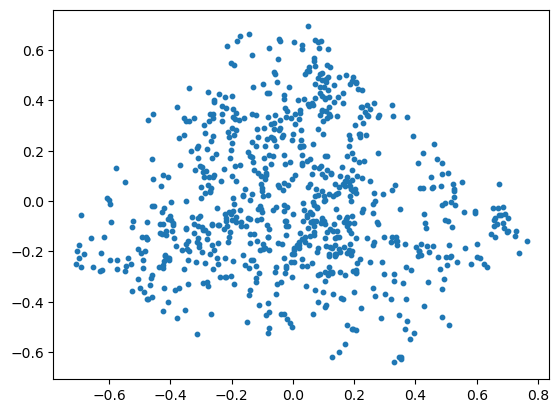

In [79]:
pca_10 = PCA(10)

df_numbers = x
df_numbers['defaultfull'] = y

df_numbers_n = normalize(df_numbers[df_numbers['defaultfull'] == 1], axis=1)
df_pc = pd.DataFrame(pca_10.fit_transform(df_numbers_n))

plt.scatter(df_pc[0], df_pc[1], marker='.', s=40)

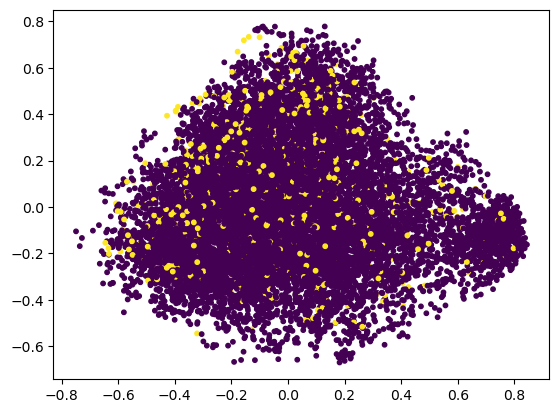

In [100]:
pca_10 = PCA(10)

df_numbers_n = normalize(df_numbers, axis=1)
df_pc = pd.DataFrame(pca_10.fit_transform(df_numbers_n))

plt.scatter(df_pc[0], df_pc[1], c=df_numbers['defaultfull'], marker='.', s=40)

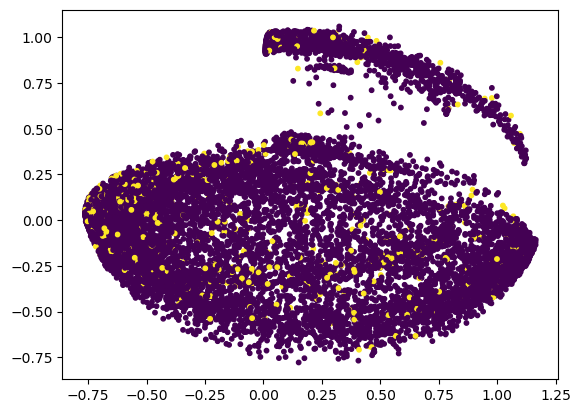

In [104]:
pca_2 = PCA(2)

df_numbers_n = normalize(df_numbers[best_forward_features_n[-1]], axis=1)
df_pc = pd.DataFrame(pca_2.fit_transform(df_numbers_n))

plt.scatter(df_pc[0], df_pc[1], c=df_numbers['defaultfull'], marker='.', s=40)

0.08689915267796372 0.06597508659490497


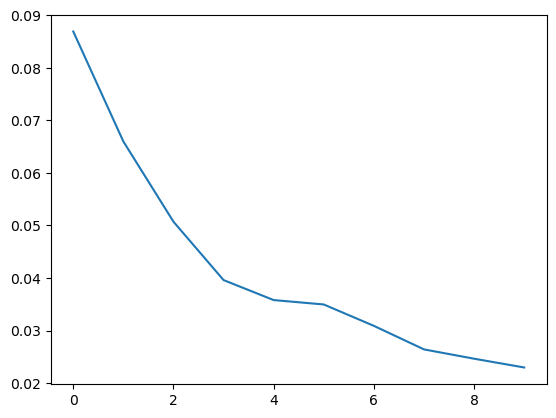

In [102]:
plt.plot(pca_10.explained_variance_ratio_)
print(pca_10.explained_variance_ratio_[0], pca_10.explained_variance_ratio_[1])